# Exercise sheet 10

## NWO grant applications

### Exercise 1

For this exercise, you will need to load the dataset NWOGrants from the rethinking package. This dataset reports on the funding outcomes of the Netherlands Organisation for Scientific Research (NWO) grant applications over the 2010-2012 period. One study used that dataset to investigate gender bias in the funding awards: https://www.pnas.org/content/112/40/12349. You can read there that a response to this paper has been formulated, as briefly discussed at the beginning of lecture 9. Note that in general less than half applications are awarded funding.

Address the same question as the one in the paper by Lee and Ellemers by using binomial GLM to investigate potential gender bias on awards. Quantify the contrast between male and female applicants. In a second step, condition on the discipline as well. What are your conclusions? Should the NWO take specific measures for gender equity in general and across disciplines? Is there any excess variance in the data? If yes, can you elaborate on the nature of possible unaccounted sources?

In [45]:
library(rethinking)
data(NWOGrants)
d <- NWOGrants

In [46]:
d$male <- as.integer(d$gender) - 1
d$field <- as.integer(d$discipline)
d$accept <- d$awards / d$applications
d <- d[order(d$field), ]
d$accept.scaled <- scale(d$accept)
d

,discipline,gender,applications,awards,male,field,accept,accept.scaled
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,"<dbl[,1]>"
1,Chemical sciences,m,83,22,1,1,0.2650602,1.41716126
2,Chemical sciences,f,39,10,0,1,0.2564103,1.25309407
13,Earth/life sciences,m,156,38,1,2,0.2435897,1.00992305
14,Earth/life sciences,f,126,18,0,2,0.1428571,-0.90070635
7,Humanities,m,230,33,1,3,0.1434783,-0.88892539
8,Humanities,f,166,32,0,3,0.1927711,0.04602831
11,Interdisciplinary,m,105,12,1,4,0.1142857,-1.44263033
12,Interdisciplinary,f,78,17,0,4,0.2179487,0.52358102
17,Medical sciences,m,245,46,1,5,0.1877551,-0.04911153


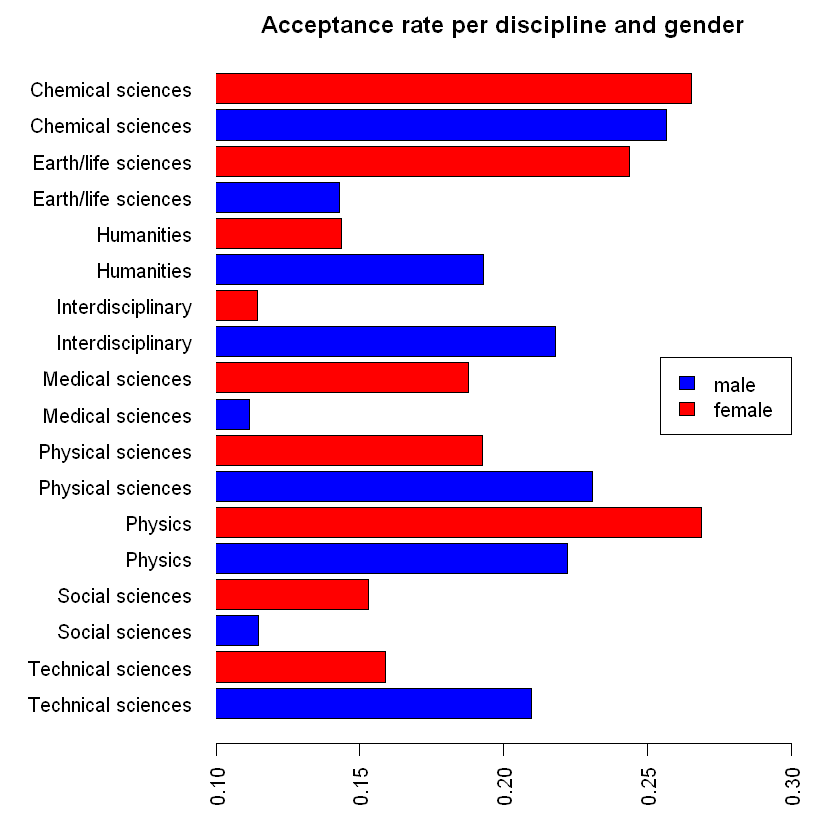

In [47]:
par(mar = c(4, 9, 2, 2))
barplot(rev(d$accept), names.arg = rev(d$discipline), las=2, xlim = c(0.10, 0.30), xpd = FALSE, horiz = TRUE, col = ifelse(d$male, "blue", "red"))
title("Acceptance rate per discipline and gender")
legend("right", c("male", "female"), fill = c("blue", "red"))

So male applicants are more likely to get accepted in humanities, interdiciplinary, physical and technical sciences. Female applicants are more likely to get accepted in chemical, earth/life, medical and social sciences and in physics.

In [48]:
e <- data.frame(discipline = character(), applications = integer(), awards = integer(), field = integer(), accept = double())
for (field in 1:max(d$field)) {
	dat <- d[d$field == field, ]
	discipline <- as.character(dat$discipline[1])
	applications <- sum(dat$applications)
	awards <- sum(dat$awards)
	accept <- awards / applications
	e[nrow(e) + 1, ] <- list(discipline, applications, awards, field, accept)
}
e

,discipline,applications,awards,field,accept
,<chr>,<int>,<int>,<int>,<dbl>
1,Chemical sciences,122,32,1,0.2622951
2,Earth/life sciences,282,56,2,0.1985816
3,Humanities,396,65,3,0.1641414
4,Interdisciplinary,183,29,4,0.1584699
5,Medical sciences,505,75,5,0.1485149
6,Physical sciences,174,35,6,0.2011494
7,Physics,76,20,7,0.2631579
8,Social sciences,834,112,8,0.1342926
9,Technical sciences,251,43,9,0.1713147


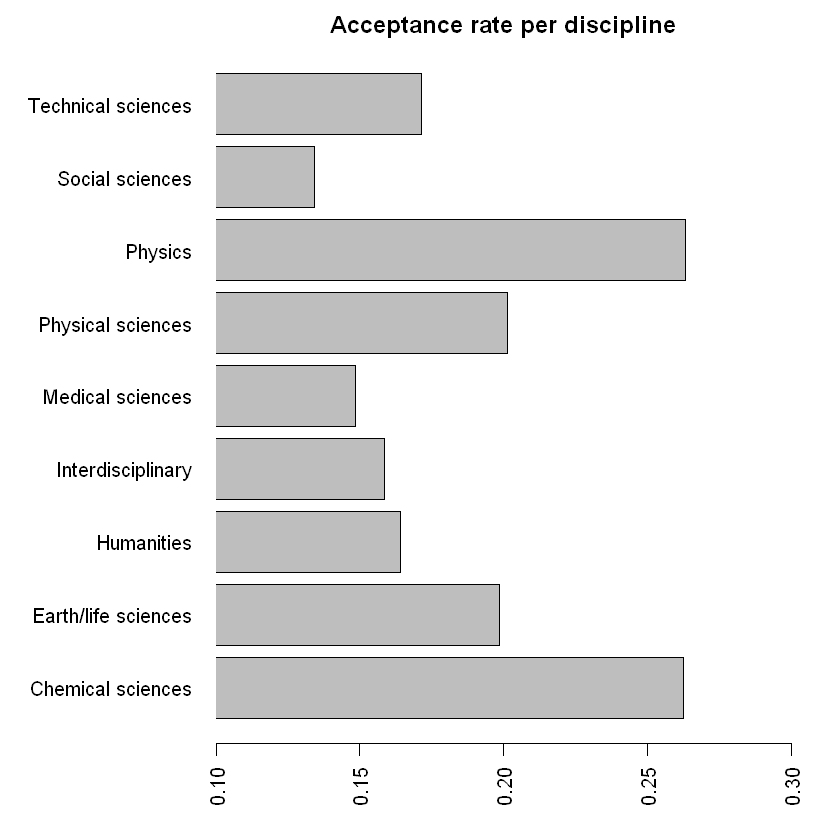

In [49]:
par(mar = c(4, 9, 2, 2))
barplot(e$accept, names.arg = e$discipline, las=2, xlim = c(0.10, 0.30), xpd = FALSE, horiz = TRUE)
title("Acceptance rate per discipline")

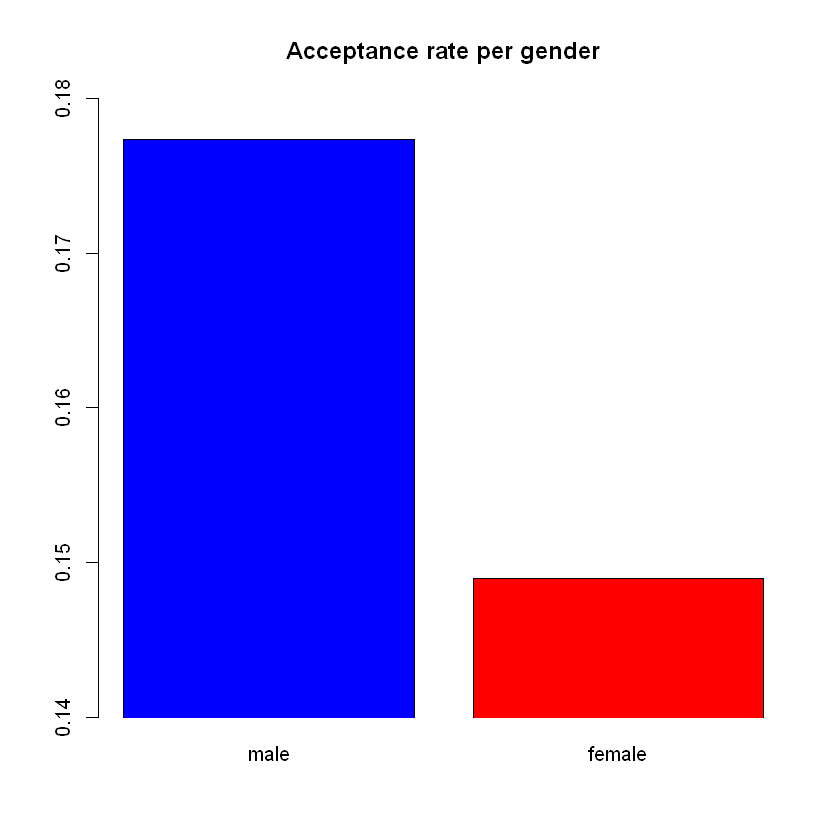

In [50]:
male_applications <- sum(d[d$male == 1, ]$applications)
female_applications <- sum(d[d$male == 0, ]$applications)
male_awards <- sum(d[d$male == 1, ]$awards)
female_awards <- sum(d[d$male == 0, ]$awards)
male_accept <- male_awards / male_applications
female_accept <- female_awards / female_applications

barplot(c(male_accept, female_accept), names.arg = c("male", "female"), ylim = c(0.14, 0.18), xpd = FALSE, col = c("blue", "red"))
title("Acceptance rate per gender")

So in the data there is a difference between the male and female acceptance rate in the data. But is it statistically significant? We construct different models and compare them.

In [51]:
# A single mean over all the data
model1 <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a,
		a ~ dnorm(0, 10)
	),
	data = d
)
model1_parameter_amount <- 1 # 1

In [52]:
# One mean for male and one mean for female
model_male <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a + a_male * male,
		a ~ dnorm(0, 10),
		a_male ~ dnorm(0, 10)
	),
	data = d
)
model_male_parameter_amount <- 1 + 1 # 2

In [53]:
# A model where we dont distinguish between male and female, but the department is relevant
model_field <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a[field],
		a[field] ~ dnorm(0, 10)
	),
	data = d
)
model_field_parameter_amount <- nrow(e) # 9

In [54]:
# Each field has its own mean but the change if a participant is male is global
model_field_male <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a[field] + a_male * male,
		a[field] ~ dnorm(0, 10),
		a_male ~ dnorm(0, 10)
	),
	data = d
)
model_field_male_parameter_amount <- nrow(e) + 1 # 10

In [55]:
# We have the same mean for all fields, but the influence if the participant is male is unique for each field
model_male_field <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a + a_male[field] * male,
		a ~ dnorm(0, 10),
		a_male[field] ~ dnorm(0, 10)
	),
	data = d
)
model_male_field_parameter_amount <- 1 + nrow(e) # 10

In [56]:
# Both the mean and the offset for a male participant is different for each department
model_field_male_field <- map(
	alist(
		awards ~ dbinom(applications, p),
		logit(p) <- a[field] + a_male[field] * male,
		a[field] ~ dnorm(0, 10),
		a_male[field] ~ dnorm(0, 10)
	),
	data = d
)
model6_field_male_field_parameter_amount <- nrow(e) + nrow(e) # 18

In [57]:
compare(model1, model_male, model_field, model_field_male, model_male_field, model_field_male_field)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_field_male_field,115.3864,3.369967,0.000000,NA,9.403273,0.9627751468
model_male_field,122.1434,7.578640,6.756988,6.004410,7.179558,0.0328294541
model_field,127.8052,9.378538,12.418740,7.443691,11.837350,0.0019356634
model_male,129.0930,8.572148,13.706568,7.420293,4.365616,0.0010166735
model_field_male,129.3019,8.286532,13.915449,6.737752,13.004343,0.0009158480
model1,130.4064,12.923662,15.019937,12.038474,2.865637,0.0005272141


So we see that the model that is able to distinguish between male and female and also between departments is able to fit the data the best, obviously.

Now we quantify the contrast while disregarding the field the participants come from. These are the two models ```model_male``` and ```model1```. Because the latter is gender independent, we only have to do this discussion one for the first model.

In [69]:
# The relative scale, which in most cases can be disregarded.
summary(model_male)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.7424187,0.08147002,-1.87262358,-1.6122139
a_male,0.2081422,0.10405972,0.04183467,0.3744497


In [70]:
post <- extract.samples(model_male)
p.award.male <- logistic(post$a + post$a_male)
p.award.female <- logistic(post$a)
diff.award <- p.award.male - p.award.female
quantile(diff.award, c(0.025, 0.5, 0.975))

[1] 0.1937143 0.1850358 0.1803084 0.1570239 0.1785370 0.1850893 0.1712652
    [8] 0.1597466 0.1931744 0.1714215 0.1756261 0.1744141 0.1705950 0.1805869
   [15] 0.1669114 0.1717891 0.1714953 0.1740956 0.1688959 0.1709189 0.1853473
   [22] 0.1805102 0.1872397 0.1780781 0.2034139 0.1827408 0.1881560 0.1823167
   [29] 0.1679459 0.1834796 0.1719861 0.1652232 0.1665452 0.1709867 0.2002364
   [36] 0.1777207 0.1687092 0.1839909 0.1770409 0.1742493 0.1777884 0.1770402
   [43] 0.1726904 0.1790804 0.1816395 0.1759511 0.1957912 0.1607666 0.1834235
   [50] 0.1814634 0.1835666 0.1913418 0.2004290 0.1937722 0.1650967 0.1902334
   [57] 0.1687635 0.1866053 0.1684299 0.1660069 0.1659326 0.1845197 0.1868352
   [64] 0.1805803 0.1853610 0.1600650 0.1707445 0.1855787 0.1784708 0.1639354
   [71] 0.1639828 0.1847931 0.1861955 0.1813843 0.1655862 0.1710589 0.1917526
   [78] 0.1623252 0.1723851 0.1560421 0.1684108 0.1661188 0.1770590 0.1710681
   [85] 0.1634189 0.1785069 0.1911949 0.1732223 0.1873586 0.1850851 0.1976479
   [92] 0.1678337 0.1821485 0.1686689 0.1672544 0.1672086 0.1907778 0.1715575
   [99] 0.1759836 0.1736345 0.1724437 0.1669256 0.1759307 0.1698199 0.1768460
  [106] 0.1709268 0.1772749 0.1713986 0.1928679 0.1711981 0.1795136 0.1803633
  [113] 0.1846996 0.1781861 0.1806101 0.1727579 0.1584594 0.1765109 0.1847405
  [120] 0.1765041 0.1707490 0.1850929 0.1601339 0.1749226 0.1822641 0.1799257
  [127] 0.1934342 0.1599351 0.1666462 0.1840105 0.1739031 0.1874622 0.1908465
  [134] 0.1689335 0.1905955 0.1880152 0.1636648 0.1772566 0.1843941 0.1926906
  [141] 0.1760520 0.1768184 0.1767923 0.1685504 0.1763751 0.1652213 0.1821779
  [148] 0.1778135 0.1823414 0.1755399 0.1677336 0.1651390 0.1775098 0.1919897
  [155] 0.1809299 0.1714560 0.1759821 0.1815852 0.1784405 0.1667753 0.1671294
  [162] 0.1740267 0.1917322 0.1875688 0.1809643 0.1878208 0.1795041 0.1764473
  [169] 0.1687782 0.1666854 0.1883963 0.2014944 0.1893851 0.1837362 0.1683661
  [176] 0.1886909 0.1818661 0.1837095 0.1812863 0.1700179 0.1909322 0.1656662
  [183] 0.1728017 0.1633955 0.1746475 0.1743264 0.1683954 0.1795154 0.1778257
  [190] 0.1854758 0.1659123 0.1822678 0.1947277 0.1812464 0.1882134 0.1807649
  [197] 0.1811139 0.1797549 0.1877815 0.1851510 0.1713089 0.1870005 0.1817414
  [204] 0.1650478 0.1795263 0.1782236 0.1862366 0.1772178 0.1683244 0.1815726
  [211] 0.1705487 0.1888136 0.1624183 0.1682029 0.1746653 0.1728181 0.1680615
  [218] 0.1828637 0.1889421 0.1610882 0.1962004 0.1783280 0.1849682 0.2059294
  [225] 0.1881422 0.1834328 0.1788297 0.1848919 0.1760204 0.1781959 0.1736363
  [232] 0.1803239 0.1894602 0.1802505 0.1782161 0.1860162 0.1940338 0.1830169
  [239] 0.1747610 0.1798342 0.1944429 0.1830440 0.1725828 0.1732066 0.1734263
  [246] 0.1618345 0.1592004 0.1838293 0.1656794 0.1641892 0.2006371 0.1753730
  [253] 0.1793059 0.1766589 0.1852322 0.1887034 0.1720327 0.1853599 0.1806670
  [260] 0.1738814 0.1847286 0.1813851 0.1766743 0.1734387 0.1695870 0.1837768
  [267] 0.1701661 0.1719799 0.1858745 0.1565402 0.1637906 0.1633892 0.1708621
  [274] 0.1723264 0.1929496 0.1766601 0.1831289 0.1838511 0.1713510 0.1711346
  [281] 0.1737088 0.1739558 0.1878362 0.1775246 0.1714418 0.1819433 0.1797113
  [288] 0.1630698 0.1913797 0.1778257 0.1803559 0.1899287 0.1866874 0.1770099
  [295] 0.1719344 0.1686238 0.1826808 0.1934672 0.1767870 0.1855609 0.1667811
  [302] 0.1718344 0.1905120 0.1743244 0.1773945 0.1821192 0.1692189 0.1725929
  [309] 0.1789124 0.1842235 0.1643440 0.1664591 0.1733344 0.1632568 0.1838430
  [316] 0.1883986 0.1934434 0.1822356 0.1768071 0.1723161 0.1775338 0.1792865
  [323] 0.1734108 0.1896372 0.1838978 0.1718415 0.1722921 0.1735907 0.1992140
  [330] 0.1581725 0.1704833 0.1749791 0.1690270 0.1991644 0.1766447 0.1707095
  [337] 0.1850182 0.1884943 0.1825798 0.1765746 0.1896418 0.1726279 0.1729229
  [344] 0.1685330 0.1631323 0.1619740 0.1837264 0.1717694 0.1668590 0.1757647
  [351] 0.1628691 0.1791228 0.1534589 0.1677284 0.1821003 0.1832666 0.1670094
  [358] 0.1710523 0.183832

2.5%          50%        97.5% 
0.0009659402 0.0283858640 0.0555567671